In [10]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['legend.numpoints'] = 1
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import metrics
from sklearn import multiclass
from sklearn import svm
from scipy.stats import ttest_ind
import os
from scipy.spatial import distance

disease1,disease2='nsclc','lihc' #
sns.set_style("white")

def cdist_df(df1,df2):
    df1T,df2T=df1.T, df2.T
    corrM=1-distance.cdist(df1T,df2T,metric='correlation')
    return pd.DataFrame(corrM,index=df1.columns,columns=df2.columns  )

# data cleaning

In [11]:
trainSize=100
maxRead=10000.0*10000
minRead=3.0*10000
topNMarkers=50 #per Diagnosis
binning=True
mitoGenes=False
randomSeed=1

In [12]:
#methylation data input dir
DataInDir="./inData/"
#results output dirs
resultBaseDir='./Results/'
#input fdirs

mical_rd_df_dir=DataInDir+'readcount.pickle'
mical_beta_df_dir=DataInDir+'methyl.pickle'
#table output dir

resultPrefixFmt='{baseDir}/binning_{binningState}_{disease1}_{disease2}_'
resultPrefix=resultPrefixFmt.format(baseDir=resultBaseDir,binningState=binning,disease1=disease1,disease2=disease2)


In [13]:
#data dir
classification_stat=resultPrefix+'_classify_stat.xlsx'
basicCountOutDir=resultPrefix+'_stat.xlsx'
cancer_vs_normalOutDir=resultPrefix+'_cancer_vs_normal_score.xlsx' 
cancer_vs_cancerOutDir=resultPrefix+'_{disease1}_vs_{disease2}_score.xlsx'.format(disease1=disease1,disease2=disease2)
cox_OutDir=resultPrefix+'_cox.xlsx'
p_val_Df=resultPrefix+'_clin_pval.xlsx'
#plots dir
aucFigDir=resultPrefix+"_auc.pdf"
compositeScoreDir=resultPrefix+'_composite_score.pdf'
boxplotDir=resultPrefix+'_marker_boxplot.pdf'
violinplotDir=resultPrefix+'_marker_violinplot.pdf'
kenDataDir=resultPrefix+'_kenMatrix.xlsx'
readCountFigDir=resultPrefix+"_all_read_count.pdf"
covariate_composite_score_FigDir=resultPrefix+'_{plotType}_{disease}.pdf'
kaplanMeier_FigDir=resultPrefix+'_{disease}_km.pdf'
marker_OutDfDir=resultPrefix+'_multiclass_marker.xlsx'
cancer_vs_cancer_fig_dir=resultPrefix+'_cancer_vs_cancer_heatmap.pdf'
normal_vs_cancer_fig_dir=resultPrefix+'_cancer_vs_normal_heatmap.pdf'
diag_hmap_dir=resultPrefix+'_diag_heatmap.png'
binaryContingencyDir=resultPrefix+'binary_class_stat_score.xlsx'
twoStepOutExcelDir=resultPrefix+'_normal_vs_cancer____cancer_vs_cancer.xlsx'

In [14]:
print "CWD: ",os.getcwd()+'/'+resultBaseDir

CWD:  /cellar/users/btsui/Project/KangZhang/V6/./Results/


In [15]:
#remove existing results 
if os.path.exists(resultBaseDir):
    os.system('rm -r'+resultBaseDir)
os.mkdir(resultBaseDir)

### read in data

In [16]:
selectedTissues=['normal',disease1,disease2]#,'brca',disease2
inZhangRdDf=pd.read_pickle(mical_rd_df_dir).T
inZhangBetaDf=pd.read_pickle(mical_beta_df_dir).T

### retrieving read counts 

In [17]:
methylationReadCountDf=np.multiply(inZhangBetaDf.fillna(0).astype(np.float),
                       inZhangRdDf.fillna(0).astype(np.float))

### data binning

In [18]:
if binning:
    binI=methylationReadCountDf.index.map(lambda s:s[:-2])
    methylationReadCountDf.index=pd.MultiIndex.from_arrays([binI,methylationReadCountDf.index])
logTransformedDf=np.log10(methylationReadCountDf+1).mean(axis=0,level=0)


### ignore mitochrondria reads

In [19]:
mitoMask=~logTransformedDf.index.str.contains('^M')
if mitoGenes:
    inFeatureDf=logTransformedDf
else:
    inFeatureDf=logTransformedDf[mitoMask]

In [20]:
inFeatureDf.index.name='Marker'

# complete meta data

In [21]:
all_metaDf=inFeatureDf.columns.to_series().reset_index(name='TUPLE')
all_metaDf['ReadC']=inZhangRdDf.sum(axis=0).values

### hard filtering

In [22]:
myHardFilerMask=all_metaDf.TSS.isin(selectedTissues)\
    &(all_metaDf.ReadC<maxRead)\
    &(all_metaDf.ReadC>minRead)
filtered_metaDf=all_metaDf[myHardFilerMask]

### downsampling

In [23]:
diseaseDiagnosis=set(selectedTissues)-set(['normal'])

In [24]:
normal_MetaDf=filtered_metaDf[filtered_metaDf.TSS=='normal'].sort_values(['TSS','ReadC'],
                    ascending=False)
evenSize=filtered_metaDf.TSS.value_counts().min()
diseaseDiagCohortMetaDf=filtered_metaDf[filtered_metaDf.TSS.isin(diseaseDiagnosis)]
downSampled_DiseaseMetaDf=diseaseDiagCohortMetaDf.sort_values(['TSS','ReadC'],
                    ascending=False).groupby('TSS').head(n=evenSize)
downSampled_metaDf=pd.concat([normal_MetaDf,
                                     downSampled_DiseaseMetaDf],axis=0)

### split input into training and testing

In [25]:
train_test_MetaDf=downSampled_metaDf.copy()
##shuffle the dataframe for getting training data
sampled_MetaDf=train_test_MetaDf.sample(train_test_MetaDf.shape[0],random_state=randomSeed)
#split into training and testing
trainIds=sampled_MetaDf.groupby('TSS').head(n=trainSize).ID.values
train_test_MetaDf['Train']=sampled_MetaDf.ID.isin(trainIds)

### generate sub feature df 

In [26]:
in_MetaDf=train_test_MetaDf.copy()
sub_FeatureDf=inFeatureDf.loc[:,in_MetaDf.TUPLE.values].copy()
col=in_MetaDf.set_index(['Train','TSS','ID']).index
sub_FeatureDf.columns=col

#### train to distinguish between cancer and normal

In [27]:
trainDf,testDf= sub_FeatureDf[True],sub_FeatureDf[False]

### feature selection t test

In [28]:
tmpDfList=[]
for selectedTissue1 in selectedTissues:
    for selectedTissue2 in selectedTissues:
        t,p=ttest_ind(trainDf[selectedTissue1],
                      trainDf[selectedTissue2],axis=1)
        tmpDf=pd.DataFrame( {'t':t,'p':p})
        tmpDf['TSS1']=selectedTissue1
        tmpDf['TSS2']=selectedTissue2
        tmpDf['Marker']=trainDf.index
        tmpDfList.append(tmpDf)
mergedStatTDf=pd.concat(tmpDfList,axis=0)

#filter the without valid t statistics and self comparison
subDf=mergedStatTDf[mergedStatTDf.TSS1!=mergedStatTDf.TSS2].dropna()

"""
normal markers: select the markers with high mean t stat against the cancer
"""
normalStatDf=subDf[subDf.TSS1=='normal'].groupby(['TSS1','Marker']).t.mean()
###for cancer: train only against cancer 
"""
cancer markers: select the markers with high mean t stat against the cancer
"""
cancerStatDf=subDf[(subDf.TSS1==disease1
                   )&(subDf.TSS1!='normal')&(
        subDf.TSS2!='normal')].groupby(['TSS1','Marker']).t.mean()

mergedDF=pd.concat([cancerStatDf.reset_index(),normalStatDf.reset_index()],axis=0)

multiclass_selectedMarkersDf=mergedDF.sort_values('t',ascending=True).drop_duplicates('Marker').groupby('TSS1').head(topNMarkers)

multi_calss_selectedMarkers=multiclass_selectedMarkersDf.Marker.values


### training and testing

In [29]:
cancerVsNormal_Weight_base=0.6

In [30]:
### predict using only the selected markers
subMarker_TrainDf, subMarker_TestDf=trainDf.loc[
    multi_calss_selectedMarkers],testDf.loc[multi_calss_selectedMarkers]
reg=multiclass.OneVsRestClassifier(linear_model.LogisticRegression(random_state=randomSeed))
yTrainLabel=subMarker_TrainDf.columns.get_level_values('TSS')
reg.fit(subMarker_TrainDf.T,yTrainLabel)
yTrainLabel=subMarker_TrainDf.columns.get_level_values('TSS')
yTrainLabel.value_counts()
unweighted_scoreDf=pd.DataFrame( data=reg.decision_function(subMarker_TestDf.T),
             columns=reg.classes_,index=subMarker_TestDf.columns)
unweighted_scoreDf.columns.name='Diagnosis model'
#down weigh disease diag
diseaseMask=unweighted_scoreDf.columns.get_level_values(
    'Diagnosis model').isin(diseaseDiagnosis)
disease_WeightedDf=unweighted_scoreDf.loc[:,diseaseMask]
normalVsNormal_WeightedDf=unweighted_scoreDf.loc[:,~diseaseMask]+ cancerVsNormal_Weight_base

scoreDf=pd.concat([disease_WeightedDf,normalVsNormal_WeightedDf],axis=1)


In [31]:
subMarker_TrainDf.shape ,subMarker_TestDf.shape

((100, 300), (100, 1873))

In [32]:
maxScore=scoreDf.max(axis=1)
classifiedSamples=scoreDf.idxmax(axis=1)

### export data

# plot

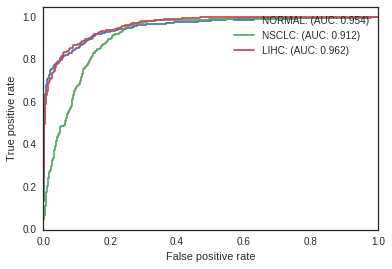

In [33]:
legendFormat="{Diag}: (AUC: {AUC})"
yLabel='Composite score'
tprLabel='True positive rate'
fprLabel='False positive rate'

aucDict={}
handles=[]
for selectedTissue in selectedTissues:
    myScoreS=scoreDf[selectedTissue]
    y=myScoreS.index.get_level_values('TSS')==selectedTissue
    fpr,tpr,_=metrics.roc_curve(y_true=y,y_score=myScoreS)
    legendStr=legendFormat.format(Diag=selectedTissue.upper(),
                       AUC=str(metrics.auc(fpr,tpr))[:5])
    handle,=plt.plot(fpr,tpr,label=legendStr)
    handles.append(handle)
plt.legend(handles=handles)
ax=plt.gca()
ax.set_xlabel(fprLabel)
ax.set_ylabel(tprLabel)
ax.set_ylim([0,1.05])
plt.savefig(aucFigDir)
#68

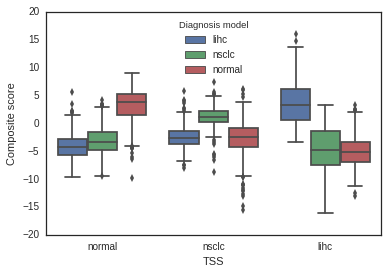

In [34]:
stackScoreDf=scoreDf.stack().reset_index(name=yLabel)
g=sns.boxplot( data=stackScoreDf,x='TSS',hue='Diagnosis model',y=yLabel)
g.figure.savefig(compositeScoreDir)

# box and violin plots

In [35]:
yLabel='Median adjusted methylated read counts'
ylim=[-1,3.5]
titleFmt="{TSS}: markers in test population"

subClassifyDf=classifiedSamples.reset_index(name='predicted_TSS').reset_index()
plotMarkers=multiclass_selectedMarkersDf.set_index('Marker').TSS1
inPlotFeatureDf=testDf
m3=inPlotFeatureDf.columns.get_level_values('ID').isin(subClassifyDf.ID)
countLabel='log10( methylated read count +1 )'
longDf=inPlotFeatureDf.loc[plotMarkers.index,:].T.stack().reset_index(
    name=countLabel)
plotMarkers=plotMarkers.groupby(plotMarkers.index).first()
longDf['markerTSS']=plotMarkers.loc[longDf.Marker].values
diagMedianS=trainDf.median(axis=0).median(axis=0,level=0)
#longDf[yLabel]=longDf[countLabel]-diagMedianS.loc[longDf.TSS].values

### box plot

In [36]:
#tissueToColorS=pd.Series(({selectedTissue:color for selectedTissue, color in
#  zip(selectedTissues,sns.color_palette("husl", len(selectedTissues)))}))

In [37]:
allDiag=longDf.TSS.unique().tolist()
diseaseDiag=[disease2,disease1]
reoderedAllDiag=diseaseDiag+['normal']

In [38]:
cancerTitleFormat='markers: {disease1} vs {disease2}'
cancerTitle=cancerTitleFormat.format(disease1=disease1,disease2=disease2)

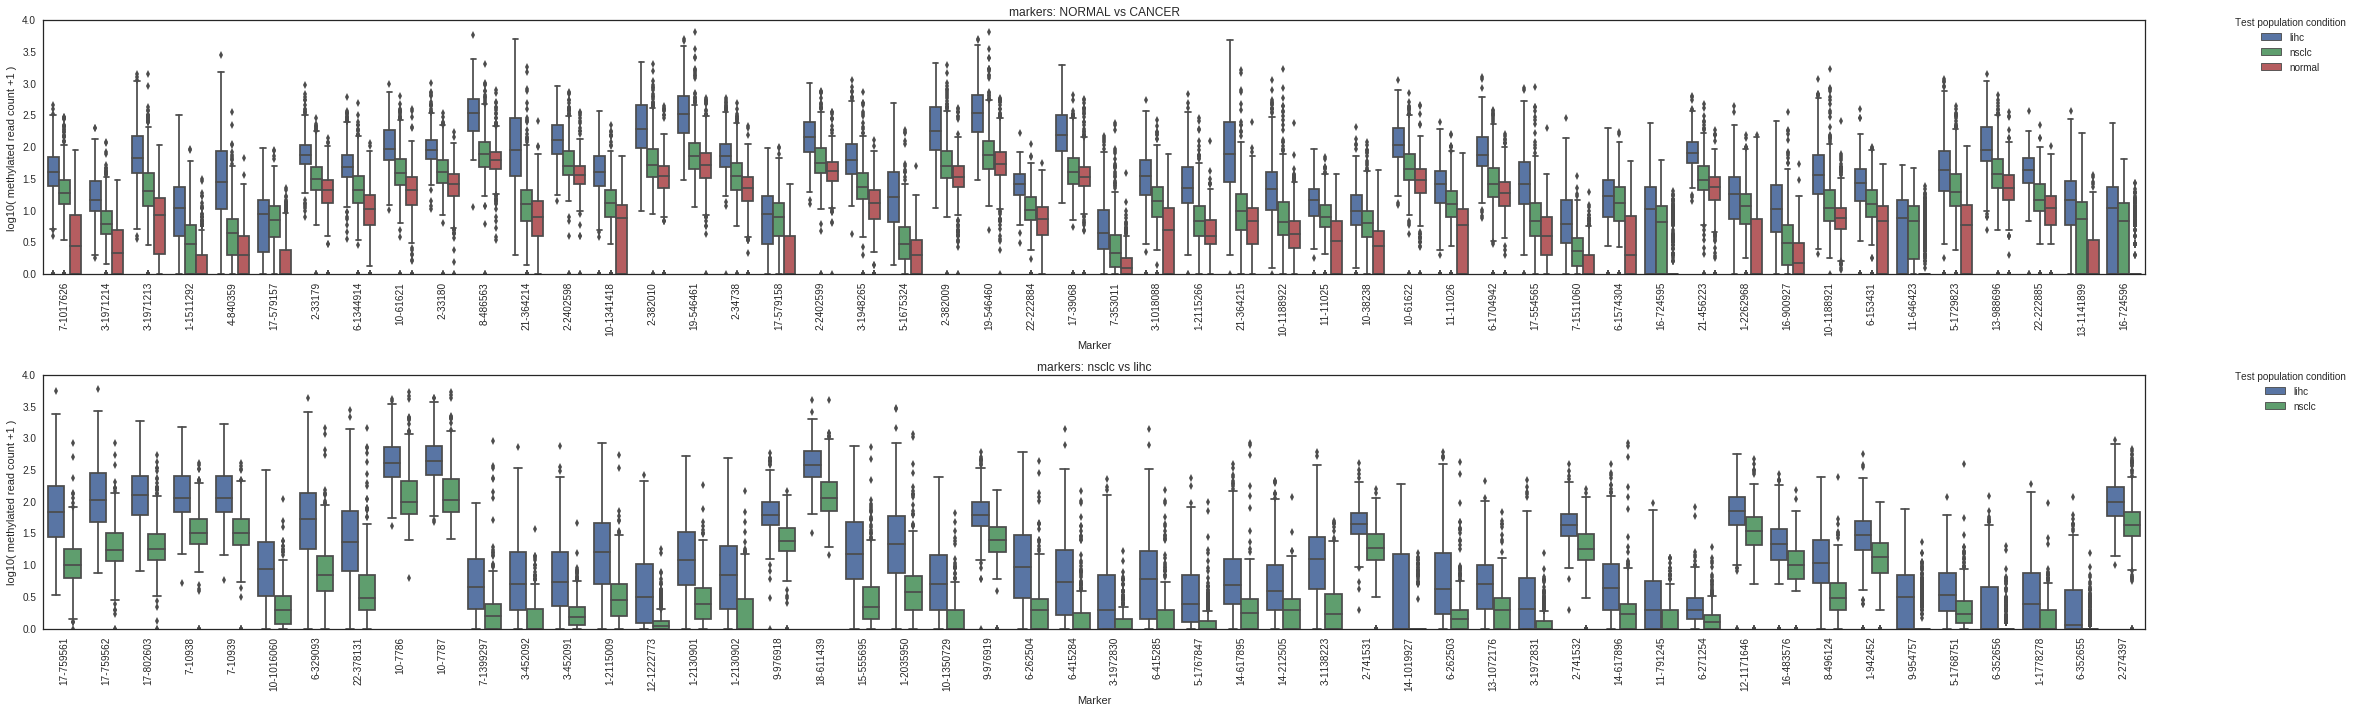

In [39]:
#plot the normal 
#cancer model
f,axes=plt.subplots(nrows=2,ncols=1,sharey=True)
fig = plt.gcf()
fig.set_size_inches(30, 10)
#generate normal subplot
cancerMarkerDf=longDf[longDf.markerTSS=='normal']
xorder=cancerMarkerDf.Marker.unique()
g=sns.boxplot( data=cancerMarkerDf,y=countLabel,x='Marker',hue='TSS',hue_order=reoderedAllDiag,ax=axes[0],order=xorder)
g.set_title('markers: NORMAL vs CANCER')
g.legend(bbox_to_anchor=(1.1,1.05),title='Test population condition')
g.set_xticklabels(xorder,rotation=90)
#generate cancer subplot
cancerMarkerDf=longDf[longDf.markerTSS==disease1]
xorder=cancerMarkerDf.Marker.unique()
g=sns.boxplot( data=cancerMarkerDf,y=countLabel,x='Marker',hue='TSS',hue_order=diseaseDiag,ax=axes[1],order=xorder)
g.set_xticklabels(xorder,rotation=90)
g.set_title(cancerTitle)
g.legend(bbox_to_anchor=(1.1,1.05),title='Test population condition')
plt.tight_layout()
f.savefig(boxplotDir,bbox_inches='tight')

### output the scoring sheet

### cancer vs normal

In [40]:
yLabel='Cancer score'

In [41]:
cancerVsNormalScoreDf=scoreDf.idxmax(axis=1).reset_index(name='predict_TSS')

In [42]:
cancerVsNormalScoreDf[yLabel]=scoreDf[diseaseDiag].max(axis=1).values

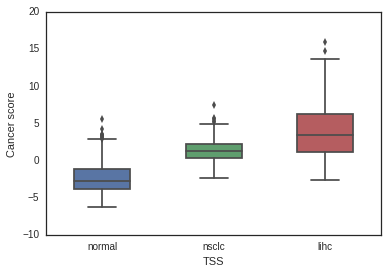

In [43]:
sns.boxplot( data=cancerVsNormalScoreDf,x='TSS',y=yLabel,width=0.5)

In [44]:
writer=pd.ExcelWriter(cancer_vs_normalOutDir)
cancerVsNormalScoreDf.to_excel(writer)
writer.close()

##### cancer versus cancer

In [45]:
m=scoreDf.index.get_level_values('TSS').isin(diseaseDiag)
subScoreDf=scoreDf.loc[m,diseaseDiag]
cancer_vs_cancer_df=subScoreDf.idxmax(axis=1).reset_index(name='predict_TSS')
cancer_vs_cancer_df[disease1+' score']=subScoreDf[disease1].values


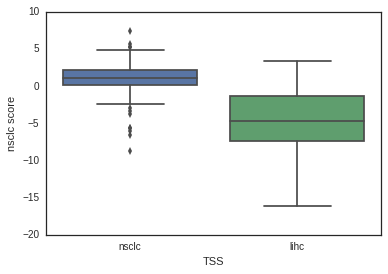

In [46]:
sns.boxplot(data=cancer_vs_cancer_df,x='TSS',y=disease1+' score')

In [47]:
writer=pd.ExcelWriter(cancer_vs_cancerOutDir)
cancer_vs_cancer_df.to_excel(writer)
writer.close()

### export data

In [48]:
"""
500-600 for both disease types
1500
"""
subClassifyDf.predicted_TSS.value_counts()

normal    746
nsclc     614
lihc      513
Name: predicted_TSS, dtype: int64

In [49]:
writer=pd.ExcelWriter(classification_stat)
for quantile in np.arange(0.,1.0,0.1):
    subClassifyDf=classifiedSamples[maxScore>maxScore.quantile(quantile)
                               ].reset_index(name='predicted_TSS').reset_index()
    if (len(subClassifyDf.TSS.value_counts())== len(selectedTissues))&\
        (len(subClassifyDf.predicted_TSS.value_counts())== len(selectedTissues)):
        multiClassDf=subClassifyDf.groupby('TSS').predicted_TSS.value_counts().unstack().fillna(0)
        contingentDf=multiClassDf
        colLabels=contingentDf.columns.values.copy()
        #input: contingentDf
        myLabel='Value'
        myCol=pd.MultiIndex.from_arrays([[myLabel]*len(colLabels),colLabels])
        all_contingentDf=contingentDf
        all_contingentDf.columns=myCol.copy()

        #'Divded by column sum: '+myCol
        myLabel='Divided by column sum'
        myCol=pd.MultiIndex.from_arrays([[myLabel]*len(colLabels),colLabels])
        column_sum_div_contingentDf=contingentDf/contingentDf.sum(axis=0)
        column_sum_div_contingentDf.columns=myCol.copy()

        #'Divded by column sum: '+myCol
        myLabel='Divided by row sum'
        myCol=pd.MultiIndex.from_arrays([[myLabel]*len(colLabels),colLabels])
        row_sum_div_contingentDf=(contingentDf.T/contingentDf.sum(axis=1)).T
        row_sum_div_contingentDf.columns=myCol.copy()
        combinedContingencyDf=pd.concat([all_contingentDf,row_sum_div_contingentDf,column_sum_div_contingentDf],
                  axis=1)
        combinedContingencyDf.index=colLabels
        combinedContingencyDf.index.name='condition'
        combinedContingencyDf.columns.names=['Data type','Predicted diagnosis']
        combinedContingencyDf.to_excel(writer,str(quantile*100)[:2])
writer.close()

In [50]:
in_MetaDf.groupby('Train').TSS.value_counts().to_frame()

TSS
Train TSS        
False normal  765
      lihc    554
      nsclc   554
True  lihc    100
      normal  100
      nsclc   100

In [51]:
#!cp ../V3/Data/Zhang_processed/clinDf.pickle ./inData/.

In [52]:
clinDf=pd.read_pickle('./inData/clinDf.pickle')

In [53]:
pIdCol='patient_ID'

In [54]:
clinDf[pIdCol]=clinDf.index.str.extract('^(\d+)-')

/cellar/users/btsui/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


### export marker list

In [55]:
#multiclass_selectedMarkersDf

In [56]:
excel=pd.ExcelWriter(marker_OutDfDir)
multiclass_selectedMarkersDf.sort_values('TSS1').to_excel(excel)
excel.close()

### train a cancer versus disease model

In [57]:
selectedMarkers=multiclass_selectedMarkersDf.Marker.values

In [58]:
### predict using only the selected markers
subMarker_TrainDf, subMarker_TestDf=trainDf.loc[selectedMarkers],testDf.loc[selectedMarkers]
reg=linear_model.LogisticRegression(random_state=randomSeed)
myModelScoreDfList=[]
for disease in diseaseDiagnosis: 
    normalAndDiseaseDf=subMarker_TrainDf.loc[:,
                                subMarker_TrainDf.columns.get_level_values('TSS').isin([disease,'normal'])]
    yTrainLabel=normalAndDiseaseDf.columns.get_level_values('TSS')==disease
    reg.fit(normalAndDiseaseDf.T,yTrainLabel)
    cancer_vs_normal_scoreDf=pd.DataFrame( data={disease:reg.decision_function(subMarker_TestDf.T)}
                                          ,index=subMarker_TestDf.columns)
    myModelScoreDfList.append(cancer_vs_normal_scoreDf)

In [59]:
myNewBinaryScoreDf=pd.concat(myModelScoreDfList,axis=1)

In [60]:
BinaryClass_Positive_Threshold=0.5
excel=pd.ExcelWriter(binaryContingencyDir)
for myDisease in diseaseDiag:
    m=myNewBinaryScoreDf.index.get_level_values('TSS').isin(['normal',myDisease])
    mySubS=myNewBinaryScoreDf.loc[m,myDisease]
    continDf=pd.DataFrame({myDisease:(mySubS>BinaryClass_Positive_Threshold).groupby(level=0).sum(),
                 'normal':(~(mySubS>BinaryClass_Positive_Threshold)).groupby(level=0).sum()})
    continDf.to_excel(excel,sheet_name=myDisease)
myNewBinaryScoreDf.to_excel(excel,sheet_name='score per model')
excel.close()

### cancer_vs_normal normal_vs_cancer

In [61]:
excel=pd.ExcelWriter(twoStepOutExcelDir)


### testing

In [62]:
postFix='_testing'
yTrainLabel=subMarker_TrainDf.columns.get_level_values('TSS').isin(diseaseDiag)
reg.fit(subMarker_TrainDf.T,yTrainLabel)
cancer_normalScore=reg.decision_function(subMarker_TestDf.T)
cancerVersusNormalScore=cancer_normalScore>BinaryClass_Positive_Threshold

m=subMarker_TrainDf.columns.get_level_values('TSS').isin(diseaseDiag)
cancerOnlyDf=subMarker_TrainDf.loc[:,m]
yTrainLabel=cancerOnlyDf.columns.get_level_values('TSS')
reg.fit(cancerOnlyDf.T,yTrainLabel)
cancerVersusCancerScore=reg.decision_function(subMarker_TestDf.T)
cancerVersusCancerPredictedLabel=reg.predict(subMarker_TestDf.T)

cancer_normal_v2Df=pd.DataFrame({'cancer_normal':cancerVersusNormalScore,
                                 'cancer_normal_score':cancer_normalScore,
                              disease1:cancerVersusCancerPredictedLabel,
                                disease1+'_score':cancerVersusCancerScore},index=subMarker_TestDf.columns)

cancer_normal_v2Df['is_cancer']=cancer_normal_v2Df.index.get_level_values('TSS')!='normal'

cancer_normal_v2Df['TSS']=cancer_normal_v2Df.index.get_level_values('TSS')

cancer_normal_contingentDf=cancer_normal_v2Df.groupby(
    ['is_cancer']).cancer_normal.value_counts().unstack()

cancerOnlyDf=cancer_normal_v2Df[cancer_normal_v2Df.TSS!='normal']
cancer_cancer_contingentDf=cancerOnlyDf.groupby(['TSS'])[disease1].value_counts().unstack()


cancer_cancer_contingentDf.to_excel(excel,sheet_name='cancer_cancer'+postFix)
cancer_normal_contingentDf.to_excel(excel,sheet_name='cancer_normal'+postFix)
cancer_normal_v2Df.to_excel(excel,sheet_name='score'+postFix)


### training

In [63]:
postFix='_training'
yTrainLabel=subMarker_TrainDf.columns.get_level_values('TSS').isin(diseaseDiag)
reg.fit(subMarker_TrainDf.T,yTrainLabel)
cancer_normalScore=reg.decision_function(subMarker_TrainDf.T)
cancerVersusNormalScore=cancer_normalScore>BinaryClass_Positive_Threshold

m=subMarker_TrainDf.columns.get_level_values('TSS').isin(diseaseDiag)
cancerOnlyDf=subMarker_TrainDf.loc[:,m]
yTrainLabel=cancerOnlyDf.columns.get_level_values('TSS')
reg.fit(cancerOnlyDf.T,yTrainLabel)
cancerVersusCancerScore=reg.decision_function(subMarker_TrainDf.T)
cancerVersusCancerPredictedLabel=reg.predict(subMarker_TrainDf.T)

cancer_normal_v2Df=pd.DataFrame({'cancer_normal':cancerVersusNormalScore,
                                 'cancer_normal_score':cancer_normalScore,
                              disease1:cancerVersusCancerPredictedLabel,
                                disease1+'_score':cancerVersusCancerScore}
                                ,index=subMarker_TrainDf.columns)

cancer_normal_v2Df['is_cancer']=cancer_normal_v2Df.index.get_level_values('TSS')!='normal'

cancer_normal_v2Df['TSS']=cancer_normal_v2Df.index.get_level_values('TSS')

cancer_normal_contingentDf=cancer_normal_v2Df.groupby(
    ['is_cancer']).cancer_normal.value_counts().unstack()

cancerOnlyDf=cancer_normal_v2Df[cancer_normal_v2Df.TSS!='normal']
cancer_cancer_contingentDf=cancerOnlyDf.groupby(['TSS'])[disease1].value_counts().unstack()


cancer_cancer_contingentDf.to_excel(excel,sheet_name='cancer_cancer'+postFix)
cancer_normal_contingentDf.to_excel(excel,sheet_name='cancer_normal'+postFix)
cancer_normal_v2Df.to_excel(excel,sheet_name='score'+postFix)


In [64]:
excel.close()

input: inputScoreDf

# analysis with clinical

In [65]:
inputScoreDf=myNewBinaryScoreDf.copy().reset_index()
inputScoreDf[pIdCol]=inputScoreDf.ID.str.extract('^(\d+)-')

/cellar/users/btsui/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


### merge with clinical

In [66]:
myScoreMergedDf=pd.merge(left=inputScoreDf,right=clinDf,on=pIdCol)

In [67]:
plotNameToPlotF_Dict={'violin':sns.violinplot,'box':sns.boxplot}

In [68]:
burdenOrder=['Y','N']

In [69]:
sdPrLabel='sd+pr'

In [70]:
myScoreMergedDf['response']=myScoreMergedDf['response'].replace('pr',sdPrLabel)
myScoreMergedDf['response']=myScoreMergedDf['response'].replace('sd',sdPrLabel)

In [71]:
myScoreMergedDf.loc[myScoreMergedDf.TSS=='nsclc','stage']=myScoreMergedDf.loc[myScoreMergedDf.TSS=='nsclc','stage'].replace(2,1)
myScoreMergedDf.loc[myScoreMergedDf.TSS=='nsclc','stage']=myScoreMergedDf.loc[myScoreMergedDf.TSS=='nsclc','stage'].replace(3,4)
myScoreMergedDf.loc[myScoreMergedDf.TSS=='lihc','stage']=myScoreMergedDf.loc[myScoreMergedDf.TSS=='lihc','stage'].replace(2,1)
myScoreMergedDf.loc[myScoreMergedDf.TSS=='lihc','stage']=myScoreMergedDf.loc[myScoreMergedDf.TSS=='lihc','stage'].replace(3,4)

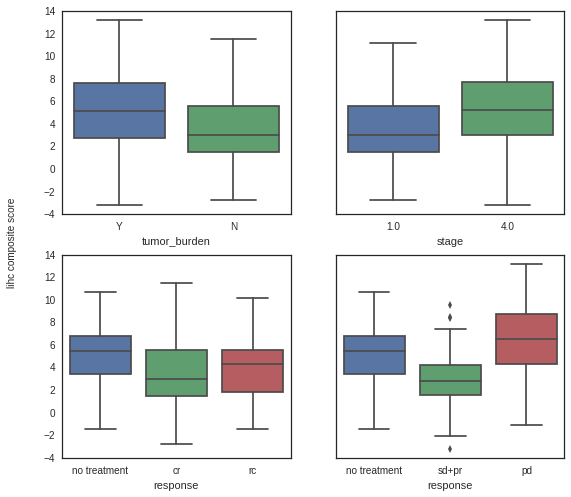

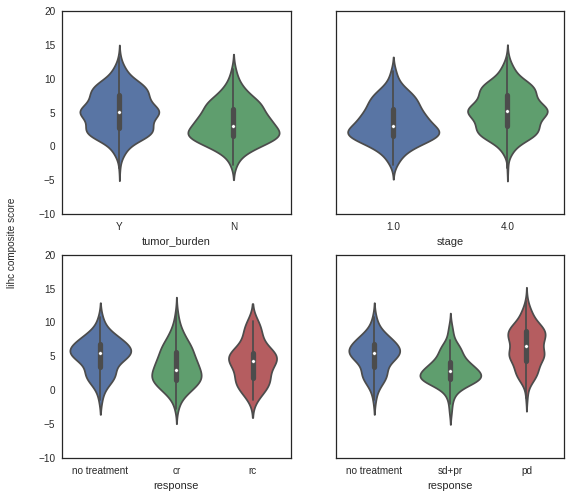

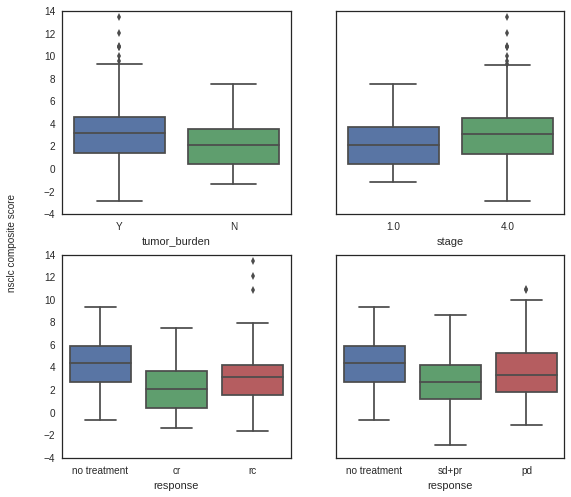

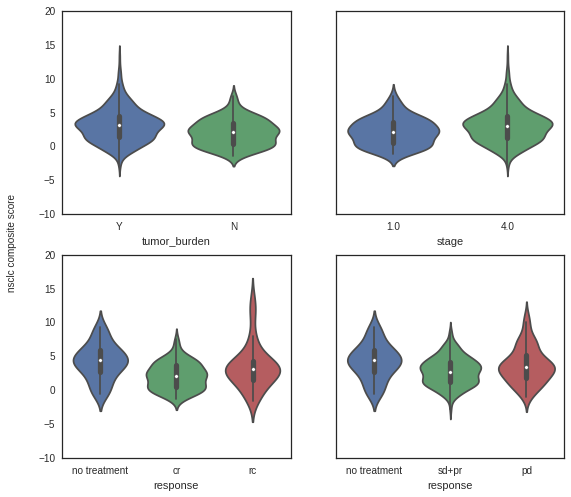

In [72]:
response1=['no treatment','cr','rc']
response2=['no treatment',sdPrLabel,'pd']
for myDiag in diseaseDiag:
    for plotName, plotF in plotNameToPlotF_Dict.iteritems():
        #tumor burden
        my_ylabel=''
        myFigOutDir=covariate_composite_score_FigDir.format(plotType=plotName,disease=myDiag)
        fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=True, figsize=(9, 8))
        ax=plotF( data= myScoreMergedDf[myScoreMergedDf.TSS==myDiag],x='tumor_burden',y=myDiag,order=burdenOrder,ax=axes[0,0])
        ax.set_ylabel(my_ylabel)
        #stage 
        ax=plotF( data= myScoreMergedDf[myScoreMergedDf.TSS==myDiag],x='stage',y=myDiag,ax=axes[0,1])
        ax.set_ylabel(my_ylabel)
        #response 1 
        ax=plotF(data=myScoreMergedDf[myScoreMergedDf.TSS==myDiag],x='response',y=myDiag,order=response1,ax=axes[1,0])
        ax.set_ylabel(my_ylabel)
        #response 2 
        ax=plotF(data=myScoreMergedDf[myScoreMergedDf.TSS==myDiag],x='response',y=myDiag,order=response2,ax=axes[1,1])
        ax.set_ylabel(my_ylabel)
        fig.text(0.04, 0.5, myDiag+' composite score', va='center', rotation='vertical')
        fig.savefig(myFigOutDir)

### p value generation

##### compare stage 2 below and above

In [73]:
myResultDict={}
for myDiag in diseaseDiag:
    A=myScoreMergedDf[(myScoreMergedDf['stage']>=3)&(myScoreMergedDf.TSS==myDiag)][myDiag]
    B=myScoreMergedDf[(myScoreMergedDf['stage']<=2)&(myScoreMergedDf.TSS==myDiag)][myDiag]
    t,p=ttest_ind(A,B)
    if t>0:
        onesided_p=p/2 
    else:
        onesided_p=1
    myResultDict[myDiag]={'t':t,'p':onesided_p}
stage_above_below_df=pd.DataFrame(myResultDict).T
stage_above_below_df

,p,t
lihc,3.507797e-10,6.282591
nsclc,1.644001e-03,2.953315


##### compare tumor burden

In [74]:
myResultDict={}
for myDiag in diseaseDiag:
    A=myScoreMergedDf[(myScoreMergedDf['tumor_burden']=='Y')&(myScoreMergedDf.TSS==myDiag)][myDiag]
    B=myScoreMergedDf[(myScoreMergedDf['tumor_burden']=='N')&(myScoreMergedDf.TSS==myDiag)][myDiag]
    t,p=ttest_ind(A,B)
    if t>0:
        onesided_p=p/2 
    else:
        onesided_p=1
    myResultDict[myDiag]={'t':t,'p':onesided_p}
tumorBurdenDf=pd.DataFrame(myResultDict).T
tumorBurdenDf

,p,t
lihc,4.101266e-08,5.436143
nsclc,1.778894e-05,4.169424


##### compare response 1

In [75]:
#'no treatment', 'cr'
#'cr', 'rc'
myResultDict={}
for myDiag in diseaseDiag:
    A=myScoreMergedDf[(myScoreMergedDf['response']=='no treatment')&(myScoreMergedDf.TSS==myDiag)][myDiag]
    B=myScoreMergedDf[(myScoreMergedDf['response']=='cr')&(myScoreMergedDf.TSS==myDiag)][myDiag]
    t,p=ttest_ind(A,B)
    if t>0:
        onesided_p=p/2 
    else:
        onesided_p=1
    myResultDict[myDiag]={'t':t,'p':onesided_p}
cr_NoTreat_Df=pd.DataFrame(myResultDict).T
cr_NoTreat_Df

,p,t
lihc,1.630289e-04,3.663940
nsclc,1.057280e-07,5.449573


In [76]:
myResultDict={}
for myDiag in diseaseDiag:
    A=myScoreMergedDf[(myScoreMergedDf['response']=='rc')&(myScoreMergedDf.TSS==myDiag)][myDiag]
    B=myScoreMergedDf[(myScoreMergedDf['response']=='cr')&(myScoreMergedDf.TSS==myDiag)][myDiag]
    t,p=ttest_ind(A,B)
    if t>0:
        onesided_p=p/2 
    else:
        onesided_p=1
    myResultDict[myDiag]={'t':t,'p':onesided_p}
cr_rc_Df=pd.DataFrame(myResultDict).T
cr_rc_Df

,p,t
lihc,0.090363,1.343790
nsclc,0.001196,3.093067


##### compare response 2

In [77]:
myResultDict={}
for myDiag in diseaseDiag:
    A=myScoreMergedDf[(myScoreMergedDf['response']=='no treatment')&(myScoreMergedDf.TSS==myDiag)][myDiag]
    B=myScoreMergedDf[(myScoreMergedDf['response']==sdPrLabel)&(myScoreMergedDf.TSS==myDiag)][myDiag]
    t,p=ttest_ind(A,B)
    if t>0:
        onesided_p=p/2 
    else:
        onesided_p=1
    myResultDict[myDiag]={'t':t,'p':onesided_p}
pr_sd_treatment_Df=pd.DataFrame(myResultDict).T
pr_sd_treatment_Df

,p,t
lihc,1.026159e-07,5.445162
nsclc,3.503368e-05,4.035670


In [78]:
myResultDict={}
for myDiag in diseaseDiag:
    A=myScoreMergedDf[(myScoreMergedDf['response']=='pd')&(myScoreMergedDf.TSS==myDiag)][myDiag]
    B=myScoreMergedDf[(myScoreMergedDf['response']==sdPrLabel)&(myScoreMergedDf.TSS==myDiag)][myDiag]
    t,p=ttest_ind(A,B)
    if t>0:
        onesided_p=p/2 
    else:
        onesided_p=1
    myResultDict[myDiag]={'t':t,'p':onesided_p}
pd_pr_sd_Df=pd.DataFrame(myResultDict).T
pd_pr_sd_Df

,p,t
lihc,4.084411e-20,9.795420
nsclc,4.997032e-04,3.319542


### export dfs into excel

In [79]:
#stage_above_below_df,tumorBurdenDf,cr_NoTreat_Df,cr_rc_Df,pr_sd_treatment_Df,pd_pr_sd_Df
excel=pd.ExcelWriter(p_val_Df)
stage_above_below_df.to_excel(excel,sheet_name='stage')

tumorBurdenDf.to_excel(excel,sheet_name='tumor burden')
cr_NoTreat_Df.to_excel(excel,sheet_name='cr_noTreatment')

cr_rc_Df.to_excel(excel,sheet_name='cr_rc')
pr_sd_treatment_Df.to_excel(excel,sheet_name='prsd_treatment')
pd_pr_sd_Df.to_excel(excel,sheet_name='prsd_sd')
excel.close()

### kaplan meier

In [80]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
from lifelines.statistics import logrank_test

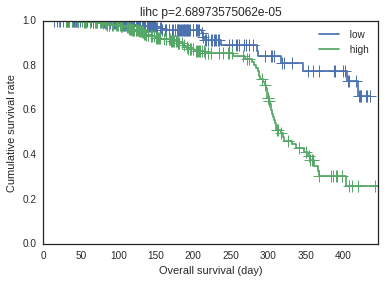

In [81]:
myDiag='lihc'
ax = plt.subplot(111)
subDf=myScoreMergedDf[myScoreMergedDf.TSS==myDiag].copy()
#event, days
tmpDf2=subDf[['event','days',myDiag]].dropna()
quantile=0.5
lowMask,highMask=tmpDf2[myDiag]<=tmpDf2[myDiag].quantile(quantile),tmpDf2[myDiag]>=tmpDf2[myDiag].quantile(1-quantile)
lDf,hDf=tmpDf2[lowMask],tmpDf2[highMask]
lDf
kmf.fit(lDf.days, event_observed=lDf.event==True, label=" low")
kmf.plot(ax=ax,ci_show=False,show_censors=True)
kmf.fit(hDf.days, event_observed=hDf.event==True, label=" high")
kmf.plot(ax=ax,ci_show=False,show_censors=True)
ax.set_ylabel('Cumulative survival rate')
ax.set_xlabel('Overall survival (day)')
results = logrank_test(hDf.days, lDf.days, hDf.event==True, lDf.event==True, alpha=.99 )
ax.set_title(myDiag+' p='+str(results.p_value))
ax.set_ylim([0,1.0])
ax.figure.savefig(kaplanMeier_FigDir.format(disease=myDiag))

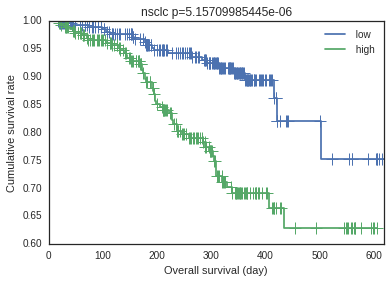

In [82]:
myDiag='nsclc'
ax = plt.subplot(111)
subDf=myScoreMergedDf[myScoreMergedDf.TSS==myDiag].copy()
#event, days
tmpDf2=subDf[['event','days',myDiag]].dropna()
quantile=0.5
lowMask,highMask=tmpDf2[myDiag]<=tmpDf2[myDiag].quantile(quantile),tmpDf2[myDiag]>=tmpDf2[myDiag].quantile(1-quantile)
lDf,hDf=tmpDf2[lowMask],tmpDf2[highMask]
kmf.fit(lDf.days, event_observed=lDf.event==True, label=" low")
kmf.plot(ax=ax,ci_show=False,show_censors=True)
kmf.fit(hDf.days, event_observed=hDf.event==True, label=" high")
kmf.plot(ax=ax,ci_show=False,show_censors=True)
ax.set_ylabel('Cumulative survival rate')
ax.set_xlabel('Overall survival (day)')
results = logrank_test(hDf.days, lDf.days, hDf.event==True, lDf.event==True, alpha=.99 )
ax.set_title(myDiag+' p='+str(results.p_value))
ax.set_ylim([0.6,1.0])
ax.figure.savefig(kaplanMeier_FigDir.format(disease=myDiag))

## cox regression

In [83]:
from lifelines import CoxPHFitter

cf = CoxPHFitter()

In [84]:
coxExcel=pd.ExcelWriter(cox_OutDir)

In [85]:
myDiag='nsclc'
myCoxDf=myScoreMergedDf[myScoreMergedDf.TSS==myDiag]
myCoxDf['sex_num']=myCoxDf['sex']=='M'
subCoxDf=myCoxDf[[myDiag,'sex_num','age','stage','days','event']].dropna().astype(np.float)
cf.fit(subCoxDf, duration_col='days', event_col='event')
cf.summary.to_excel(coxExcel,sheet_name=myDiag)

/cellar/users/btsui/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/cellar/users/btsui/anaconda/lib/python2.7/site-packages/lifelines/fitters/coxph_fitter.py:285: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(duration_col, inplace=True)


In [86]:
myDiag='lihc'
myCoxDf=myScoreMergedDf[myScoreMergedDf.TSS==myDiag]
myCoxDf['sex_num']=myCoxDf['sex']=='M'
subCoxDf=myCoxDf[[myDiag,'sex_num','age','stage','days','event']].dropna().astype(np.float)
cf.fit(subCoxDf, duration_col='days', event_col='event')
cf.summary.to_excel(coxExcel,sheet_name=myDiag)

/cellar/users/btsui/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [87]:
coxExcel.close()

# make the heatmap 

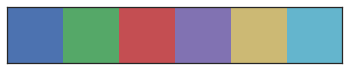

In [88]:
current_palette = sns.color_palette()
colorMapS=pd.Series( {'lihc': current_palette[0],
                      'nsclc': current_palette[1],
                     'normal':current_palette[2],
                     'cancer':current_palette[3]})
sns.palplot(current_palette)

### all three

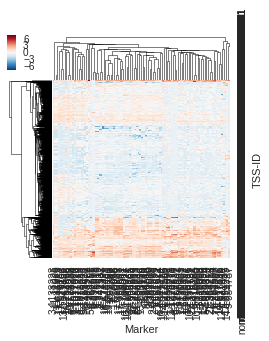

In [89]:
m=multiclass_selectedMarkersDf.TSS1.isin(diseaseDiag)
mySelectedMarkers=multiclass_selectedMarkersDf.Marker

#input: marker list, testDf
m=testDf.columns.get_level_values('TSS').isin(diseaseDiag)
markerBasedClusteringDf=testDf.loc[mySelectedMarkers]

inZDf=markerBasedClusteringDf.T
outZDf=(inZDf-inZDf.mean(axis=0))/inZDf.std(axis=0)

#clustered_tissues=clusterdDf.index.get_level_values('TSS')
cmap=sns.clustermap(outZDf,figsize=(4,4),method='average')
clusterdDf=(cmap.data2d).copy()
clustered_tissues=clusterdDf.index.get_level_values('TSS')

colors=colorMapS.loc[clustered_tissues].tolist()

In [90]:
len(colors),clusterdDf.shape

(1873, (1873, 100))

[]

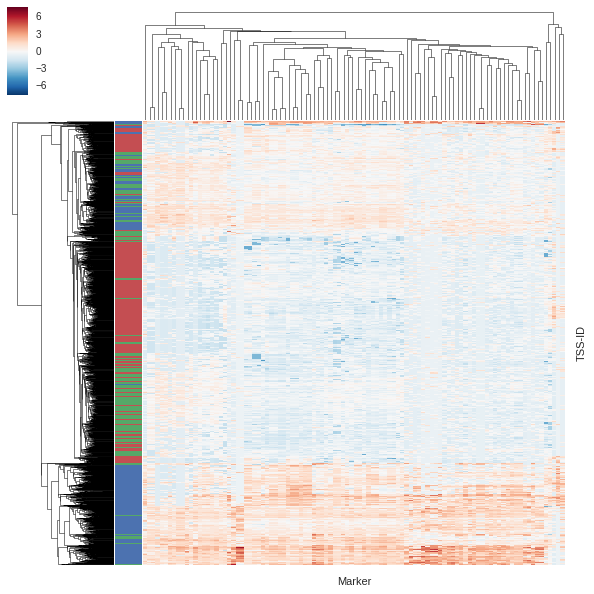

In [91]:
g=sns.clustermap(data=clusterdDf,row_cluster=True, col_cluster=True,
      row_colors=colors)
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_xticklabels([])
#

In [92]:
g.savefig(diag_hmap_dir,dpi=600)

# cancer versus cancer among cancer markers

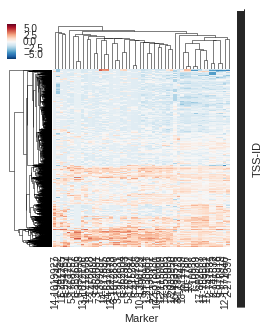

In [ ]:
m=multiclass_selectedMarkersDf.TSS1.isin(diseaseDiag)
mySelectedMarkers=multiclass_selectedMarkersDf.Marker[m]

#input: marker list, testDf
m=testDf.columns.get_level_values('TSS').isin(diseaseDiag)
markerBasedClusteringDf=testDf.loc[mySelectedMarkers,m]

inZDf=markerBasedClusteringDf.T
outZDf=(inZDf-inZDf.mean(axis=0))/inZDf.std(axis=0)

#clustered_tissues=clusterdDf.index.get_level_values('TSS')

cmap=sns.clustermap(outZDf,figsize=(4,4),method='average')

clusterdDf=(cmap.data2d).copy()
clustered_tissues=clusterdDf.index.get_level_values('TSS')

colors=colorMapS.loc[clustered_tissues].tolist()

In [ ]:
g=sns.clustermap(data=clusterdDf,row_cluster=True, col_cluster=True,
      row_colors=colors)
g.ax_heatmap.set_yticklabels([])
g.savefig(cancer_vs_cancer_fig_dir)

### normal versus cancer

In [ ]:
m=~multiclass_selectedMarkersDf.TSS1.isin(diseaseDiag)
mySelectedMarkers=multiclass_selectedMarkersDf.Marker[m]
#input: marker list, testDf
markerBasedClusteringDf=testDf.loc[mySelectedMarkers]


In [ ]:
inZDf=markerBasedClusteringDf.T
outZDf=(inZDf-inZDf.mean(axis=0))/inZDf.std(axis=0)
cmap=sns.clustermap(outZDf,figsize=(4,4),method='average')
clusterdDf=(cmap.data2d).copy()

In [ ]:
clustered_tissues=clusterdDf.index.get_level_values('TSS')

In [ ]:
myCol=clustered_tissues.copy()
cancerNormalCol=myCol.str.replace(disease1+"|"+disease2,'cancer')

In [ ]:
colors=colorMapS.loc[cancerNormalCol].tolist()

In [ ]:
#clusterdDf.index.to_series()

In [ ]:
g=sns.clustermap(data=clusterdDf,row_cluster=True, col_cluster=True,
      row_colors=colors)
g.ax_heatmap.set_yticklabels([])
g.savefig(normal_vs_cancer_fig_dir)

In [ ]:
cmap=sns.clustermap(outZDf,figsize=(4,4),method='average')
clusterdDf=(cmap.data2d).copy()
clustered_tissues=clusterdDf.index.get_level_values('TSS')
colors=colorMapS.loc[clustered_tissues].tolist()

### export inFeatureDf

In [ ]:
inFeatureDf.to_csv(resultPrefix+'inFeature_df.csv')